# Phase 2: Data Formatting and Outlier Removal

This notebook focuses on formatting categorical and numerical columns in the Beijing housing dataset for analysis readiness. It also identifies and removes outliers in the `totalPrice` column to ensure robust data quality. Key steps include mapping categorical values to meaningful strings, converting object-type columns to appropriate numerical formats, and applying advanced outlier detection techniques.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from scipy.stats import iqr

# Configure logging for reproducibility
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load cleaned dataset
try:
    housing = pd.read_csv('housing_no_missing.csv', encoding='gbk')
    logger.info(f"Dataset loaded successfully. Shape: {housing.shape}")
except FileNotFoundError:
    logger.error("File 'housing_no_missing.csv' not found.")
    raise

# Display initial dataset info
housing.info()

2025-04-09 23:18:41,258 - INFO - Dataset loaded successfully. Shape: (318819, 18)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318819 entries, 0 to 318818
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Lng                  318819 non-null  float64
 1   Lat                  318819 non-null  float64
 2   tradeTime            318819 non-null  object 
 3   DOM                  318819 non-null  float64
 4   totalPrice           318819 non-null  float64
 5   square               318819 non-null  float64
 6   livingRoom           318819 non-null  int64  
 7   drawingRoom          318819 non-null  int64  
 8   kitchen              318819 non-null  int64  
 9   bathRoom             318819 non-null  int64  
 10  floor                318819 non-null  object 
 11  constructionTime     318819 non-null  object 
 12  renovationCondition  318819 non-null  int64  
 13  buildingStructure    318819 non-null  int64  
 14  ladderRatio          318819 non-null  float64
 15  elevator         

## Part 1: Formatting Categorical Columns

Convert numerical codes in `elevator`, `subway`, `buildingStructure`, and `renovationCondition` to meaningful string labels for better interpretability.

In [2]:
# Define mapping dictionaries
mappings = {
    'elevator': {1: 'has elevator', 0: 'no elevator'},
    'subway': {1: 'has subway', 0: 'no subway'},
    'buildingStructure': {
        1: 'unknown', 2: 'mixed', 3: 'brick and wood',
        4: 'concrete', 5: 'steel', 6: 'steel-concrete composite'
    },
    'renovationCondition': {
        1: 'other', 2: 'rough', 3: 'Simplicity', 4: 'hardcover'
    }
}

# Create a copy and apply mappings
housing_categorical = housing.copy()
for column, mapping in mappings.items():
    housing_categorical[column] = housing_categorical[column].map(mapping)
    if housing_categorical[column].isnull().any():
        logger.warning(f"Mapping for '{column}' introduced NaN values.")

# Validate categorical conversion
logger.info("Categorical columns converted successfully.")
housing_categorical.head()

2025-04-09 23:19:19,020 - INFO - Categorical columns converted successfully.


,Lng,Lat,tradeTime,DOM,totalPrice,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,subway,district
0,116.475489,40.019520,2016-08-09,1464.0,415.0,131.00,2,1,1,1,高 26,2005,Simplicity,steel-concrete composite,0.217,has elevator,has subway,7
1,116.453917,39.881534,2016-07-28,903.0,575.0,132.38,2,2,1,2,高 22,2004,hardcover,steel-concrete composite,0.667,has elevator,no subway,7
2,116.561978,39.877145,2016-12-11,1271.0,1030.0,198.00,3,2,1,3,中 4,2005,Simplicity,steel-concrete composite,0.500,has elevator,no subway,7
3,116.438010,40.076114,2016-09-30,965.0,297.5,134.00,3,1,1,1,底 21,2008,other,steel-concrete composite,0.273,has elevator,no subway,6
4,116.428392,39.886229,2016-08-28,927.0,392.0,81.00,2,1,1,1,中 6,1960,rough,mixed,0.333,no elevator,has subway,1


## Part 2: Formatting Numerical Columns

Convert `constructionTime` to an integer type after removing rows with 'unknown' values. Investigate `floor` for potential numerical extraction.

In [3]:
# Check unique values in constructionTime
logger.info(f"Unique values in constructionTime: {housing_categorical['constructionTime'].unique()}")

# Remove rows with 'unknown' (Chinese character '未知')
housing_construction = housing_categorical[housing_categorical['constructionTime'] != '未知'].copy()
housing_construction['constructionTime'] = housing_construction['constructionTime'].astype(int)

# Validate conversion
logger.info(f"constructionTime converted to int. Shape: {housing_construction.shape}")
housing_construction[['constructionTime']].head()

2025-04-09 23:19:34,933 - INFO - Unique values in constructionTime: ['2005' '2004' '2008' '1960' '1997' '2009' '2006' '1991' '2001' '1990'
 '2011' '2000' '1998' '2010' '1996' '1993' '2002' '未知' '2012' '1989'
 '2003' '2007' '1994' '1984' '1992' '2014' '1985' '2013' '1999' '1979'
 '1981' '1976' '1982' '1975' '1983' '1986' '1995' '1965' '1988' '1987'
 '2015' '1955' '1980' '1978' '1958' '1970' '1956' '1977' '1964' '1963'
 '1967' '2016' '1974' '1973' '1959' '1954' '1962' '1966' '1957' '1944'
 '1972' '1971' '1953' '1968' '1961' '1950' '1952' '1933' '1969' '1906'
 '1934' '1914']
2025-04-09 23:19:35,070 - INFO - constructionTime converted to int. Shape: (299536, 18)


,constructionTime
0,2005
1,2004
2,2005
3,2008
4,1960


In [4]:
# Investigate floor column
logger.info(f"Unique values in floor: {housing_construction['floor'].unique()}")

# Extract numerical floor number (e.g., '高 26' -> 26)
housing_floor = housing_construction.copy()
housing_floor['floor_number'] = housing_floor['floor'].str.extract(r'(\d+)').astype(float)

# Handle 'unknown' floors by imputing with median
floor_median = housing_floor['floor_number'].median()
housing_floor['floor_number'] = housing_floor['floor_number'].fillna(floor_median)
housing_floor['floor_number'] = housing_floor['floor_number'].astype(int)

# Drop original floor column
housing_floor = housing_floor.drop(columns=['floor'])

# Validate conversion
logger.info(f"floor_number extracted and converted. Shape: {housing_floor.shape}")
housing_floor[['floor_number']].head()

2025-04-09 23:19:44,570 - INFO - Unique values in floor: ['高 26' '高 22' '中 4' '底 21' '中 6' '中 8' '高 6' '高 10' '中 23' '底 11' '底 3'
 '高 24' '低 23' '中 19' '高 18' '低 25' '中 12' '中 14' '中 30' '中 27' '中 5'
 '低 18' '底 28' '中 11' '低 9' '顶 7' '顶 27' '中 17' '顶 6' '中 24' '中 15' '底 5'
 '中 29' '顶 19' '顶 5' '中 9' '低 22' '顶 18' '低 16' '高 13' '高 9' '低 6' '高 17'
 '底 6' '中 28' '低 26' '底 15' '高 16' '底 2' '中 13' '低 33' '底 14' '高 15' '底 4'
 '顶 11' '顶 16' '底 18' '顶 17' '低 14' '低 10' '底 20' '高 12' '低 31' '低 30'
 '低 19' '中 32' '低 12' '中 10' '中 16' '顶 20' '底 19' '中 31' '低 13' '底 10'
 '高 25' '中 21' '中 20' '高 20' '低 21' '低 24' '顶 4' '高 21' '高 7' '中 22' '底 1'
 '中 7' '底 8' '顶 15' '高 28' '顶 14' '顶 13' '低 20' '底 26' '低 17' '顶 24'
 '底 23' '顶 3' '顶 21' '底 24' '高 30' '高 11' '底 25' '高 27' '底 9' '低 11' '低 7'
 '低 28' '中 18' '低 15' '顶 26' '低 34' '顶 12' '中 25' '高 8' '底 17' '高 32'
 '高 19' '底 7' '顶 28' '顶 9' '高 31' '中 26' '顶 2' '顶 8' '底 32' '中 42' '底 30'
 '低 32' '底 16' '底 22' '高 14' '高 23' '底 27' '底 13' '低 27' '顶 23' '低 29'
 

,floor_number
0,26
1,22
2,4
3,21
4,6


## Part 3: Outlier Detection and Removal

Identify and remove outliers in `totalPrice` using a robust method (IQR with a wider threshold to preserve data). Visualize distributions before and after.

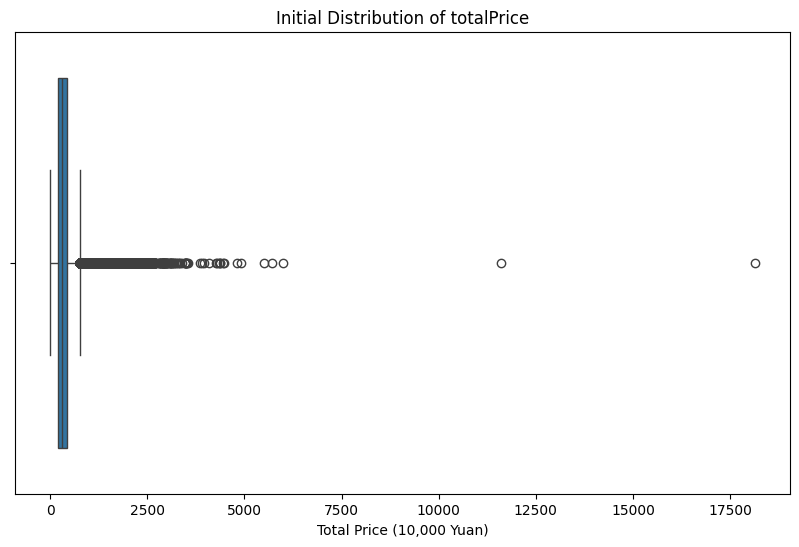

2025-04-09 23:19:52,046 - INFO - Removed 9141 outliers. New shape: (290395, 18)


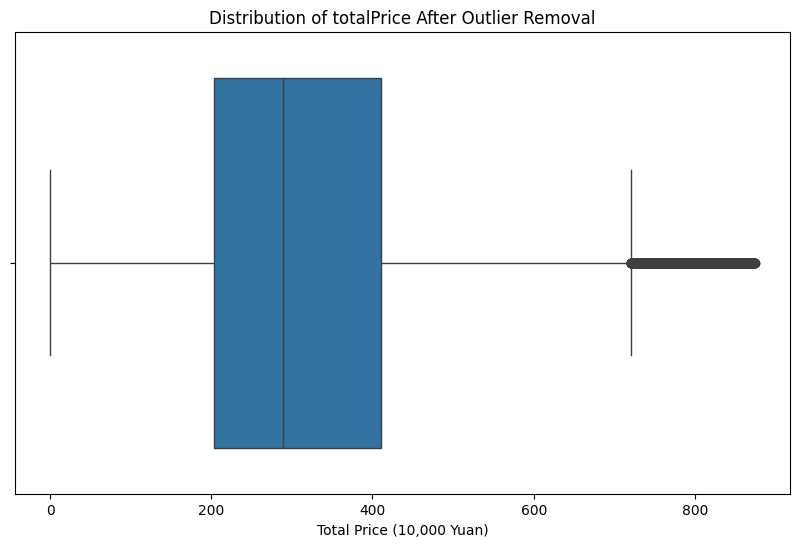

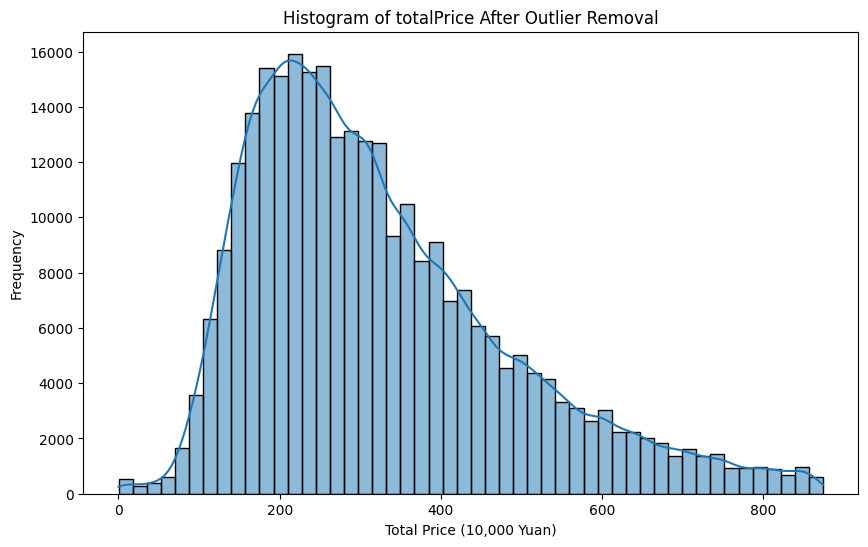

In [5]:
# Visualize initial totalPrice distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x=housing_floor['totalPrice'])
plt.title('Initial Distribution of totalPrice')
plt.xlabel('Total Price (10,000 Yuan)')
plt.show()

# Calculate IQR-based bounds with a wider threshold
Q1 = housing_floor['totalPrice'].quantile(0.25)
Q3 = housing_floor['totalPrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR  # Wider threshold
upper_bound = Q3 + 2 * IQR

# Remove outliers
housing_no_outlier = housing_floor[
    (housing_floor['totalPrice'] >= lower_bound) &
    (housing_floor['totalPrice'] <= upper_bound)
].copy()

# Log outlier removal stats
outliers_removed = len(housing_floor) - len(housing_no_outlier)
logger.info(f"Removed {outliers_removed} outliers. New shape: {housing_no_outlier.shape}")

# Visualize cleaned totalPrice distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x=housing_no_outlier['totalPrice'])
plt.title('Distribution of totalPrice After Outlier Removal')
plt.xlabel('Total Price (10,000 Yuan)')
plt.show()

# Plot histogram for additional insight
plt.figure(figsize=(10, 6))
sns.histplot(housing_no_outlier['totalPrice'], bins=50, kde=True)
plt.title('Histogram of totalPrice After Outlier Removal')
plt.xlabel('Total Price (10,000 Yuan)')
plt.ylabel('Frequency')
plt.show()

## Summary Statistics

Generate summary statistics for numerical columns to verify data quality.

In [6]:
# Summary statistics for numerical columns
numerical_cols = housing_no_outlier.select_dtypes(include=['int64', 'float64']).columns
summary_stats = housing_no_outlier[numerical_cols].describe()
logger.info("Summary statistics for numerical columns:\n%s", summary_stats)
summary_stats

2025-04-09 23:20:06,993 - INFO - Summary statistics for numerical columns:
                 Lng            Lat            DOM     totalPrice  \
count  290395.000000  290395.000000  290395.000000  290395.000000   
mean      116.418761      39.949640      14.672487     324.092971   
std         0.112448       0.093038      37.286345     162.649403   
min       116.072514      39.627030       1.000000       0.100000   
25%       116.344985      39.892118       1.000000     203.000000   
50%       116.416780      39.934282       1.000000     289.000000   
75%       116.477581      40.005016       7.000000     410.000000   
max       116.732378      40.252758    1677.000000     874.000000   

              square     livingRoom    drawingRoom        kitchen  \
count  290395.000000  290395.000000  290395.000000  290395.000000   
mean       80.636905       1.983254       1.157127       0.993939   
std        32.833912       0.747436       0.505878       0.101866   
min         7.370000       

,Lng,Lat,DOM,totalPrice,square,livingRoom,drawingRoom,kitchen,bathRoom,ladderRatio,district
count,290395.000000,290395.000000,290395.000000,290395.000000,290395.000000,290395.000000,290395.000000,290395.000000,290395.000000,2.903950e+05,290395.000000
mean,116.418761,39.949640,14.672487,324.092971,80.636905,1.983254,1.157127,0.993939,1.162754,6.931356e+01,6.737716
std,0.112448,0.093038,37.286345,162.649403,32.833912,0.747436,0.505878,0.101866,0.398342,2.626804e+04,2.819977
min,116.072514,39.627030,1.000000,0.100000,7.370000,0.000000,0.000000,0.000000,0.000000,1.400000e-02,1.000000
25%,116.344985,39.892118,1.000000,203.000000,57.660000,1.000000,1.000000,1.000000,1.000000,2.500000e-01,6.000000
50%,116.416780,39.934282,1.000000,289.000000,72.740000,2.000000,1.000000,1.000000,1.000000,3.330000e-01,7.000000
75%,116.477581,40.005016,7.000000,410.000000,96.350000,2.000000,1.000000,1.000000,1.000000,5.000000e-01,8.000000
max,116.732378,40.252758,1677.000000,874.000000,497.650000,9.000000,5.000000,3.000000,7.000000,1.000940e+07,13.000000


## Save Cleaned Data

Export the final dataset for use in subsequent analysis steps.

In [7]:
# Save cleaned dataset
housing_no_outlier.to_csv('housing_no_outlier.csv', encoding='gbk', index=False)
logger.info("Cleaned dataset saved as 'housing_no_outlier.csv'")

2025-04-09 23:20:30,636 - INFO - Cleaned dataset saved as 'housing_no_outlier.csv'


## Submission Preparation

Prepare files for submission as per requirements.

In [ ]:
import zipfile

# Save intermediate datasets (first 100 rows for submission)
housing_categorical.head(100).to_csv('housing_categorical.csv', encoding='gbk', index=False)
housing_construction.head(100).to_csv('housing_construction.csv', encoding='gbk', index=False)
housing_floor.head(100).to_csv('housing_floor.csv', encoding='gbk', index=False)
housing_no_outlier.head(100).to_csv('housing_no_outlier_100.csv', encoding='gbk', index=False)

# Compress files into result.zip
file_names = [
    'housing_categorical.csv',
    'housing_construction.csv',
    'housing_floor.csv',
    'housing_no_outlier_100.csv',
    '2_correct_format_and_outliers.ipynb'
]

with zipfile.ZipFile('result.zip', 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    for file in file_names:
        zf.write(file)
logger.info("Submission files compressed into result.zip")